# Error modeling

The matching operation in this workbook takes a long time to run. You can run these cells later but please don't run them now since they will take hours to run.

We will run two experiments for error modeling.

1. Bypass experiment
2. Dextran pulse experiment

We will see how to setup a basic error model and how to carry the error from the bypass experiment over to the dextran pulse experiment.

## Standard imports

In [1]:
#from IPython.core.display import display, HTML
from IPython.display import display, HTML, clear_output
display(HTML("<style>.container { width:100% !important; }</style>"))

#Python path library support
from pathlib import Path

#python numeric library
import numpy

#python math library
import math

#scientific library for python
import scipy

#pandas is python library for data analysis
import pandas

#addict is a library that makes it easier to create nested dictionaries
from addict import Dict

#json is a standard text based format and it used in CADETMatch for the configuration file
import json

#python plotting library
import matplotlib.pyplot as plt

#cadet python interface
from cadet import Cadet

#jupyter widget support
from ipywidgets import interact
import ipywidgets as widgets

from CADETMatch.jupyter import Match

#This is just a support function to make running the examples a bit easier later
def deleteResultDir(path):
    #This is to try and make sure that only an actual result directory can be removed
    #And only if no other files have been added to the directory, just in case
    if not path.exists():
        return
    allowed = {'evo', 'grad', 'log', 'mcmc', 'meta', 'misc', 'progress', 
               'space', 'error.csv', 'result.h5', 'progress.csv'}
    allowed.add(match.csv)
    allowed.add(match_file.name)
    okayToRemove = False
    for child in path.iterdir():
        if child.name not in allowed:
            break
    else:
        okayToRemove = True
    if okayToRemove:
        import shutil
        shutil.rmtree(path)
        
def run_match(match_obj, match_file, true_values, delete):
    "create the matching object, run it and then look at output"
    match = Match(match_file.as_posix())

    resultDir = Path(match_obj.baseDir) / match_obj.resultsDir
    print("Your results are located at", resultDir.as_posix(), '\n\n')

    #If you want to delete the fitting process to start over remove the # from the next line and re-run this cell\
    if delete:
        deleteResultDir(resultDir)

    match.start_sim()

    match.plot_best()
    best ,score, best_score = match.get_best()
    for key,value in best_score.items():
        print("Method: %s" % key)
        for name, val, true_value in zip(match.cache.parameter_headers, value, true_values):
            print("%s = %.2e  true_value = %.2e error: %.2g%%" % (name, val, true_value, numpy.abs(val-true_value)/val*100))
        print('\n')
    return match

## Setup CADET path

In order to run examples we need to specify where CADET is.

On Windows just change the cadet_bin_path to the bin directory of CADET

On Linux you need to change the cadet_bin_path and also change cadet-cli.exe to cadet-cli on the following line.

In [2]:
#put in the path to the bin folder
cadet_bin_path = Path(r"C:\Users\kosh_000\cadet_build\CADET\VCPKG\bin")

cadet_path = cadet_bin_path / "cadet-cli.exe"

if cadet_path.exists():
    print("CADET was found. Continue to the next step.")
    Cadet.cadet_path = cadet_path.as_posix()
else:
    print('CADET could not be found. Please check the bin path')
    
print(cadet_path.as_posix())

CADET was found. Continue to the next step.
C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe


## Create lesson folders and create lesson variables

This will create all the lesson folders we need and make it easier to refer to previous lessons

In [3]:
#set this to a directory on your computer where the cadet tutorial files can be saved
cadet_tutorial = Path('F:/temp/cadet_tutorial')
lesson_1 = cadet_tutorial / "lesson_1"
lesson_2 = cadet_tutorial / "lesson_2"
lesson_3 = cadet_tutorial / "lesson_3"
lesson_4 = cadet_tutorial / "lesson_4"
lesson_5 = cadet_tutorial / "lesson_5"
lesson_6 = cadet_tutorial / "lesson_6"
lesson_7 = cadet_tutorial / "lesson_7"
lesson_7.mkdir(exist_ok = True, parents=True)

# Create Bypass experiment

CompletedProcess(args=['C:/Users/kosh_000/cadet_build/CADET/VCPKG/bin/cadet-cli.exe', 'F:/temp/cadet_tutorial/lesson_7/bypass/bypass.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


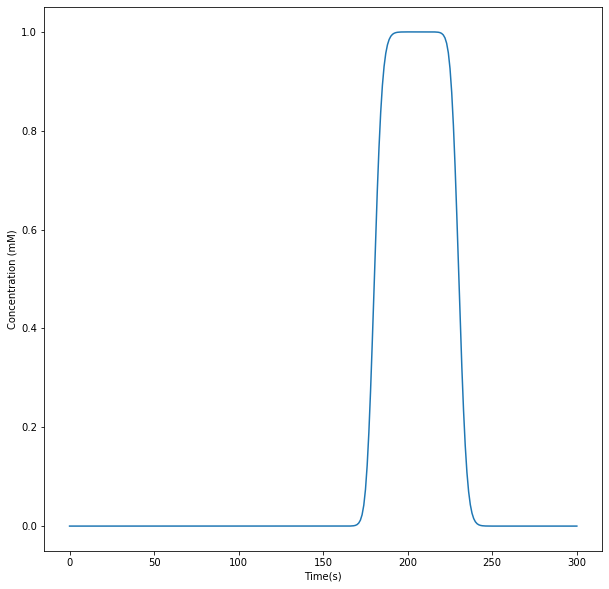

In [4]:
#simple model
simple_example = lesson_7 / "bypass"
simple_example.mkdir(exist_ok = True)

simple = Cadet()

#give a filename for where the simulation should be saved
simple.filename = (simple_example / 'bypass.h5').as_posix()

#set the number of unit operations
simple.root.input.model.nunits = 3

#nswitches is the number of different ways the units are connected in this simulation
#This is important for cyclic system and more complex setups
simple.root.input.model.connections.nswitches = 1

simple.root.input.model.connections.switch_000.section = 0

#this connects unit 0 to unit 1 and unit 1 to unit 2 with 2.88e-8 m^3/s with all components
simple.root.input.model.connections.switch_000.connections = [0, 1, -1, -1, 2.88e-8,
                                                              1, 3, -1, -1, 2.88e-8,
                                                              3, 2, -1, -1, 2.88e-8]

#create an inlet
simple.root.input.model.unit_000.unit_type = 'INLET'
simple.root.input.model.unit_000.ncomp = 1
simple.root.input.model.unit_000.inlet_type = 'PIECEWISE_CUBIC_POLY'

#const_coeff + lin_coeff*t + quad_coeff*t^2 + cube_coeff*t^3
simple.root.input.model.unit_000.sec_000.const_coeff = [1.0,]
simple.root.input.model.unit_000.sec_000.lin_coeff = [0.0,]
simple.root.input.model.unit_000.sec_000.quad_coeff = [0.0,]
simple.root.input.model.unit_000.sec_000.cube_coeff = [0.0,]

simple.root.input.model.unit_000.sec_001.const_coeff = [0.0,]
simple.root.input.model.unit_000.sec_001.lin_coeff = [0.0,]
simple.root.input.model.unit_000.sec_001.quad_coeff = [0.0,]
simple.root.input.model.unit_000.sec_001.cube_coeff = [0.0,]

#create an outlet
simple.root.input.model.unit_002.ncomp = 1
simple.root.input.model.unit_002.unit_type = 'OUTLET'

#create a column
simple.root.input.model.unit_001.unit_type = 'LUMPED_RATE_MODEL_WITHOUT_PORES'
simple.root.input.model.unit_001.ncomp = 1
simple.root.input.model.unit_001.adsorption_model = 'NONE'
simple.root.input.model.unit_001.init_c = [0.0,]
simple.root.input.model.unit_001.init_q = [0.0,]
simple.root.input.model.unit_001.col_dispersion = 2.0e-7
simple.root.input.model.unit_001.col_length = 0.25
simple.root.input.model.unit_001.total_porosity = 1.0
simple.root.input.model.unit_001.velocity = 1
simple.root.input.model.unit_001.cross_section_area = 1.0386890710931253E-5

#discretization column settings
simple.root.input.model.unit_001.discretization.ncol = 100
simple.root.input.model.unit_001.discretization.nbound = [0,]
simple.root.input.model.unit_001.discretization.use_analytic_jacobian = 1
simple.root.input.model.unit_001.discretization.reconstruction = 'WENO'
simple.root.input.model.unit_001.discretization.gs_type = 1
simple.root.input.model.unit_001.discretization.max_krylov = 0
simple.root.input.model.unit_001.discretization.max_restarts = 10
simple.root.input.model.unit_001.discretization.schur_safety = 1.0e-8

simple.root.input.model.unit_001.discretization.weno.boundary_model = 0
simple.root.input.model.unit_001.discretization.weno.weno_eps = 1e-10
simple.root.input.model.unit_001.discretization.weno.weno_order = 3

#copy the column

simple.root.input.model.unit_003 = simple.root.input.model.unit_001.copy()

#set what values get saved
simple.root.input['return'].unit_000.write_solution_bulk = 0
simple.root.input['return'].unit_000.write_solution_flux = 0
simple.root.input['return'].unit_000.write_solution_inlet = 1
simple.root.input['return'].unit_000.write_solution_outlet = 1
simple.root.input['return'].unit_000.write_solution_particle = 0

simple.root.input['return'].unit_001 = simple.root.input['return'].unit_000
simple.root.input['return'].unit_002 = simple.root.input['return'].unit_000

#automatically run the simulation in parallel
simple.root.input.solver.nthreads = 0

#set the times that the simulator writes out data for
simple.root.input.solver.user_solution_times = numpy.linspace(0, 300, 301)

#set all the tolerances for the time integrator
simple.root.input.solver.time_integrator.abstol = 1e-6
simple.root.input.solver.time_integrator.algtol = 1e-10
simple.root.input.solver.time_integrator.reltol = 1e-6
simple.root.input.solver.time_integrator.init_step_size = 1e-6
simple.root.input.solver.time_integrator.max_steps = 1000000

#solver settings
simple.root.input.solver.sections.nsec = 2
simple.root.input.solver.sections.section_times = [0.0, 50.0, 300.0]
simple.root.input.solver.sections.section_continuity = [0,]

#basic solver settings, these values should rarely be changed
simple.root.input.model.solver.gs_type = 1
simple.root.input.model.solver.max_krylov = 0
simple.root.input.model.solver.max_restarts = 10
simple.root.input.model.solver.schur_safety  = 1e-8

#save the simulation
simple.save()

#run the simulation
data = simple.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    simple.load()
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(simple.root.output.solution.solution_times,
        simple.root.output.solution.unit_002.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([simple.root.output.solution.solution_times,
                        simple.root.output.solution.unit_002.solution_outlet_comp_000]).transpose()
    data.to_csv((simple_example / 'bypass.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Create configuration file

In [5]:
match = Dict()
match.CADETPath = cadet_path.as_posix()
match.baseDir = simple_example.as_posix()
match.resultsDir = 'fit_mcmc'
match.csv = 'fit_results.csv'
match.checkpointFile = "check"
match.stopAverage = 1
match.stopBest = 1
match.gradCheck = 1
match.gradVector = 1
match.searchMethod = 'NSGA3'
match.mutationRate = 1.0
match.crossoverRate = 1.0
match.generations = 1000
match.population = 12
match.minPopulation = 12
match.maxPopulation = 12
match.finalGradRefinement = 0
match.stallGenerations = 10
match.continueMCMC = 1


error_model = Dict()
error_model.file_path = "bypass.h5"
error_model.experimental_csv = "bypass.csv"
error_model.name = "main"
error_model.units = [2,]
error_model.delay = [0.0, 3.0]
error_model.flow = [1.0, 0.03]
error_model.load = [1.0, 0.03]
error_model.error_slope = [1.0, 0.001]
error_model.error_base = 50.0
error_model.base = 50.0
error_model.count = 100

match.kde_synthetic = [error_model,]

parameter1 = Dict()
parameter1.transform = 'norm_log'
parameter1.component = -1
parameter1.bound = -1
parameter1.location = "/input/model/unit_001/COL_DISPERSION"
parameter1.min = 1e-10
parameter1.max = 1e-6

parameter2 = Dict()
parameter2.transform = 'norm_volume_length'
parameter2.component = -1
parameter2.bound = -1
parameter2.length_location = "/input/model/unit_001/COL_LENGTH"
parameter2.area_location = "/input/model/unit_001/CROSS_SECTION_AREA"
parameter2.minVolume = 1e-7
parameter2.maxVolume = 1e-5
parameter2.minLength = 0.1
parameter2.maxLength = 0.5

parameter3 = Dict()
parameter3.transform = 'set_value'
parameter3.locationFrom = "/input/model/unit_001/COL_DISPERSION"
parameter3.componentFrom = -1
parameter3.boundFrom = -1
parameter3.locationTo = "/input/model/unit_003/COL_DISPERSION"
parameter3.componentTo = -1
parameter3.boundTo = -1

parameter4 = Dict()
parameter4.transform = 'set_value'
parameter4.locationFrom = "/input/model/unit_001/COL_LENGTH"
parameter4.componentFrom = -1
parameter4.boundFrom = -1
parameter4.locationTo = "/input/model/unit_003/COL_LENGTH"
parameter4.componentTo = -1
parameter4.boundTo = -1

parameter5 = Dict()
parameter5.transform = 'set_value'
parameter5.locationFrom = "/input/model/unit_001/CROSS_SECTION_AREA"
parameter5.componentFrom = -1
parameter5.boundFrom = -1
parameter5.locationTo = "/input/model/unit_003/CROSS_SECTION_AREA"
parameter5.componentTo = -1
parameter5.boundTo = -1

match.parameters = [parameter1, parameter2, parameter3, parameter4, parameter5]

experiment1 = Dict()
experiment1.csv = "bypass.csv"
experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
experiment1.HDF5 = "bypass.h5"
experiment1.name = "main"
experiment1.timeout = 30.0

feature1 = Dict()
feature1.name = "Pulse"
feature1.type = 'DextranShape'

experiment1.features = [feature1,]

match.experiments = [experiment1,]

match_file = simple_example / 'example_bypass.json'

with (match_file).open('w') as json_file:
    json.dump(match.to_dict(), json_file, indent='\t')

## Run match

Your results are located at F:/temp/cadet_tutorial/lesson_7/bypass/fit_mcmc 


[2019-10-08 15:41:13,632] launcher  INFO    SCOOP 0.7 1.1 on win32 using Python 3.7.3 | packaged by conda-forge | (default, Jul  1 2019, 22:01:29) [MSC v.1900 64 bit (AMD64)], API: 1013

[2019-10-08 15:41:13,632] launcher  INFO    Deploying 12 worker(s) over 1 host(s).

[2019-10-08 15:41:13,632] launcher  INFO    Worker distribution: 

[2019-10-08 15:41:13,632] launcher  INFO       127.0.0.1:	11 + origin

[2019-10-08 15:41:16,381] util      (b'127.0.0.1:55908') INFO    bypass.h5 abstol=4.2e-13  reltol=0.0001

[2019-10-08 15:41:16,400] match     (b'127.0.0.1:55908') INFO    create bias template for experiment main

[2019-10-08 15:41:16,729] match     (b'127.0.0.1:55908') INFO    simulation took 0.30699992179870605

[2019-10-08 15:41:18,726] gradFD    (b'127.0.0.1:55908') INFO    grad simulation took 1.9549949169158936

[2019-10-08 15:41:18,726] gradFD    (b'127.0.0.1:55908') INFO    grad F:/temp/cadet_tutoria

[2019-10-08 15:42:36,778] util      (b'127.0.0.1:55908') INFO    Generation: 35 	Population: 36 	Average Score: 0.99 	Best: 0.999 	Minimum Score: 0.981 	Best: 0.999 	Product Score: 0.99 	Best: 0.999

[2019-10-08 15:42:38,796] util      (b'127.0.0.1:55908') INFO    Generation: 36 	Population: 36 	Average Score: 0.99 	Best: 0.999 	Minimum Score: 0.981 	Best: 0.999 	Product Score: 0.99 	Best: 0.999

[2019-10-08 15:42:40,849] util      (b'127.0.0.1:55908') INFO    Generation: 37 	Population: 36 	Average Score: 0.992 	Best: 0.999 	Minimum Score: 0.985 	Best: 0.999 	Product Score: 0.992 	Best: 0.999

[2019-10-08 15:42:43,002] util      (b'127.0.0.1:55908') INFO    Generation: 38 	Population: 36 	Average Score: 0.994 	Best: 0.999 	Minimum Score: 0.989 	Best: 0.999 	Product Score: 0.994 	Best: 0.999

[2019-10-08 15:42:44,993] util      (b'127.0.0.1:55908') INFO    Generation: 39 	Population: 36 	Average Score: 0.994 	Best: 0.999 	Minimum Score: 0.989 	Best: 0.999 	Product Score: 0.994 	Best: 0

[2019-10-08 15:43:56,538] launcher  (127.0.0.1:53283) INFO    Root process is done.

[2019-10-08 15:43:56,539] launcher  (127.0.0.1:53283) INFO    Finished cleaning spawned subprocesses.

Best item a0ece86eae2be1e62b27d323d32bc39d for meta score(s) Product Root Score , Min Score , Mean Score , SSE


,Time,Name,Method,Condition Number,COL_DISPERSION Comp:-1 Bound:-1,Area Comp:-1 Bound:-1,Length Comp:-1 Bound:-1,Volume Comp:-1 Bound:-1,main_Pulse_Shape,main_Pulse_Time,Product Root Score,Min Score,Mean Score,SSE
1,Tue Oct 8 15:42:38 2019,a0ece86eae2be1e62b27d323d32bc39d,EVO,NaN,5.805703e-08,0.000016,0.153995,0.000003,0.99898,0.99975,0.999365,0.99898,0.999365,4.210189e-17


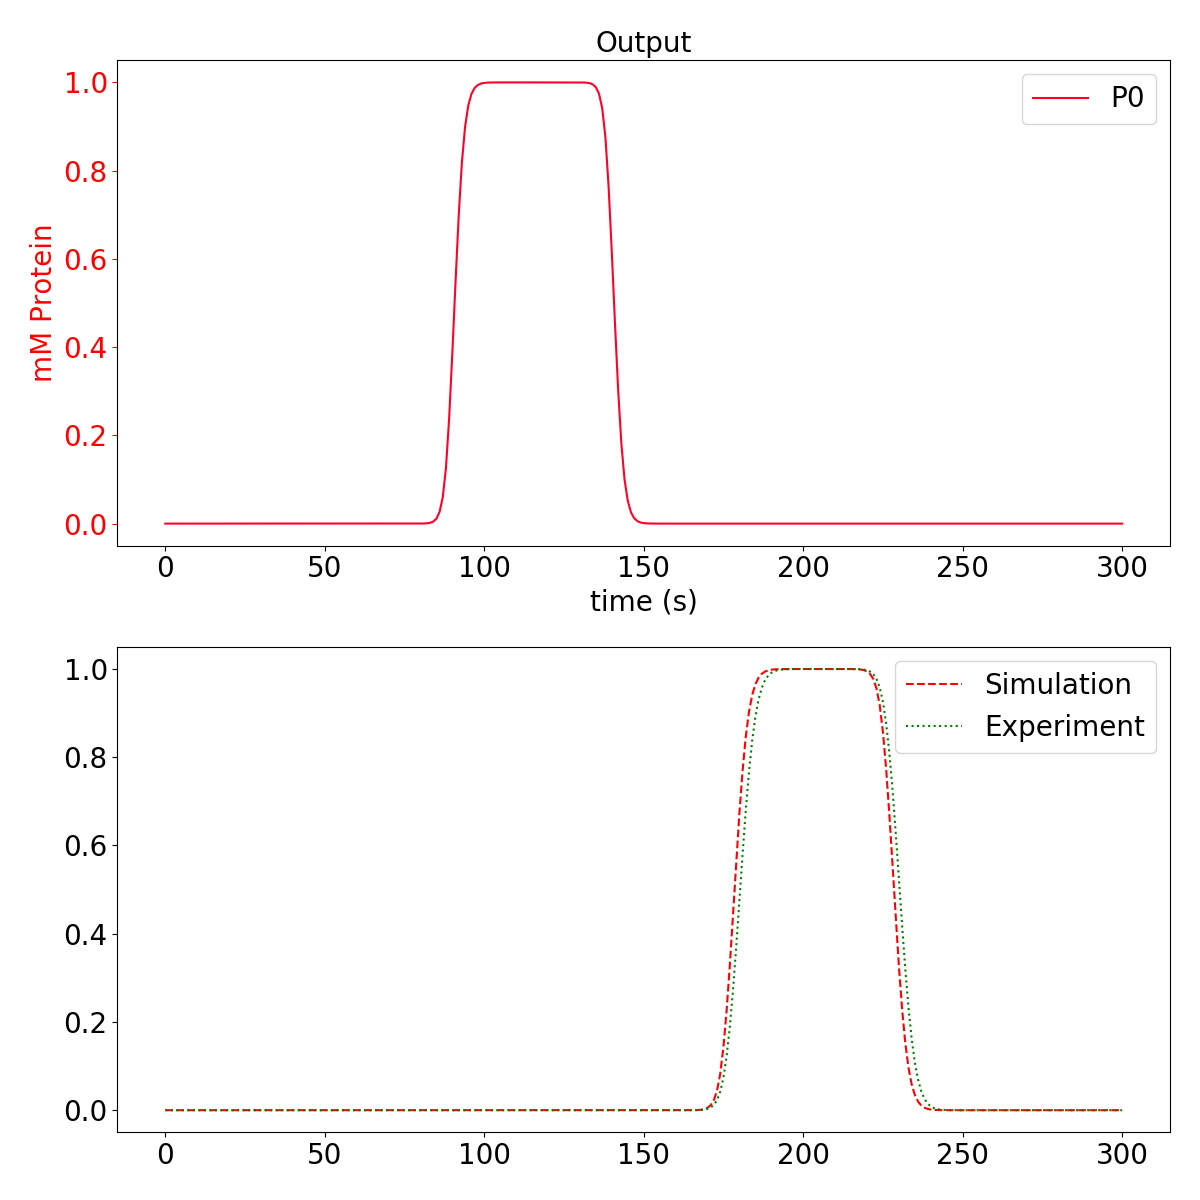

Method: Product Root Score
COL_DISPERSION Comp:-1 Bound:-1 = 5.81e-08  true_value = 2.00e-07 error: 2.4e+02%
Area Comp:-1 Bound:-1 = 1.64e-05  true_value = 2.50e-01 error: 1.5e+06%
Length Comp:-1 Bound:-1 = 1.54e-01  true_value = 1.04e-05 error: 1e+02%


Method: Min Score
COL_DISPERSION Comp:-1 Bound:-1 = 5.81e-08  true_value = 2.00e-07 error: 2.4e+02%
Area Comp:-1 Bound:-1 = 1.64e-05  true_value = 2.50e-01 error: 1.5e+06%
Length Comp:-1 Bound:-1 = 1.54e-01  true_value = 1.04e-05 error: 1e+02%


Method: Mean Score
COL_DISPERSION Comp:-1 Bound:-1 = 5.81e-08  true_value = 2.00e-07 error: 2.4e+02%
Area Comp:-1 Bound:-1 = 1.64e-05  true_value = 2.50e-01 error: 1.5e+06%
Length Comp:-1 Bound:-1 = 1.54e-01  true_value = 1.04e-05 error: 1e+02%


Method: SSE
COL_DISPERSION Comp:-1 Bound:-1 = 5.81e-08  true_value = 2.00e-07 error: 2.4e+02%
Area Comp:-1 Bound:-1 = 1.64e-05  true_value = 2.50e-01 error: 1.5e+06%
Length Comp:-1 Bound:-1 = 1.54e-01  true_value = 1.04e-05 error: 1e+02%




In [6]:
true_values = numpy.array([simple.root.input.model.unit_001.col_dispersion, 
                           simple.root.input.model.unit_001.col_length,
                          simple.root.input.model.unit_001.cross_section_area])
    
sim_non = run_match(match,
                    match_file,
                    true_values,
                    delete=True)

## View results

# Create Dextran experiment

## Create configuration file

## Run match

## View results